# Projet de _Compressed Sensing_

Enseignant : **Guillaume Lecué**  
Elèves : **Samuel Lévy, Guillaume Demonet**

ENSAE 2017

## Sujet - introduction

__*todo*__

In [72]:
import cvxopt

In [2]:
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt


## Données "_Japanese Female Expressions_"

On considère un jeu de 213 images représentant des images frontales d'expressions faciales (6 expressions spécifiques + 1 expression neutre) interprétées par 10 actrices japonaises.

In [4]:
import os

In [5]:
fnames = os.listdir("jaffe")

one, two, three = set(), set(), set()

for fn in fnames:
    try:
        a, b, c, _ = fn.split('.')
        one.add(a)
        two.add(b)
        three.add(c)
    except:
        print("WARNING : fn = '{}'".format(fn))

In [6]:
one # actress names

{'KA', 'KL', 'KM', 'KR', 'MK', 'NA', 'NM', 'TM', 'UY', 'YM'}

In [7]:
expressions = set()

for item in two:
    expressions.add(item[:2])
    
expressions

{'AN', 'DI', 'FE', 'HA', 'NE', 'SA', 'SU'}

Les expressions sont notées :

+ `"AN"` pour la colère (**ANger**)
+ `"DI"` pour le dégoût (**DIsgust**)
+ `"FE"` pour la peur (**FEar**)
+ `"HA"` pour la joie (**HAppiness**)
+ `"NE"` pour l'expression neutre (**NEutral**)
+ `"SA"` pour la tristesse (**SAdness**)
+ `"SU"` pour l'étonnement (**SUrprise**)

In [8]:
from PIL import Image

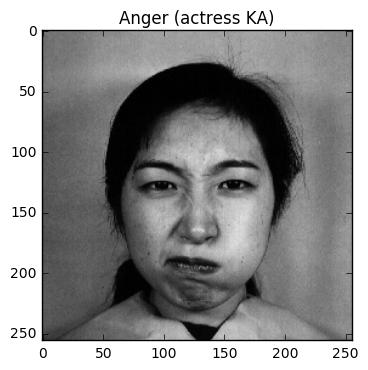

In [9]:
im = Image.open("jaffe/KA.AN1.39.tiff")

plt.title("Anger (actress KA)")
plt.imshow(im);

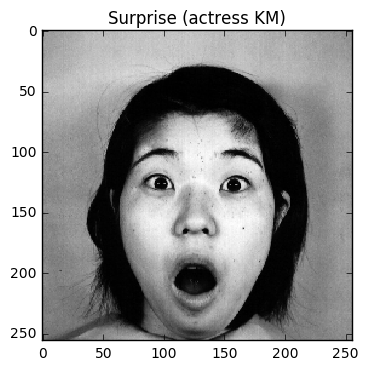

In [93]:
im = Image.open("jaffe/KM.SU1.14.tiff")

plt.title("Surprise (actress KM)")
plt.imshow(im);

In [94]:
plt.rcParams['image.interpolation'] = 'none'

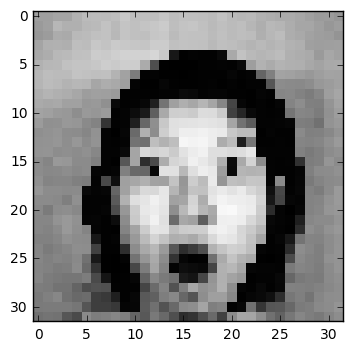

In [95]:
plt.imshow(im.resize((32,32)));

Chaque actrice correspond à une classe $k$, et l'on dispose de $J_k$ exemples pour chacune.  
L'objectif est d'exploiter le cadre du "modèle à parcimonie jointe" (_Joint Sparsity Model_) pour extraire des caractéristiques suffisantes à une classification robuste aux changements d'expression.

Le cadre défini suppose que l'on centre les observations (on soustrait "l'image moyenne") :

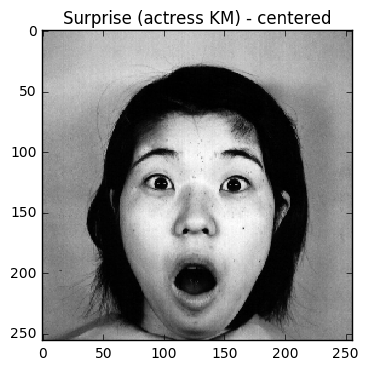

In [13]:
import numpy as np

im = np.array(im)
centered = im - np.mean(im)

plt.title("Surprise (actress KM) - centered")
plt.imshow(centered, cmap="gray");

(_il semble que la `colormap` passée à `plt.imshow` absorbe le centrage_)

On cherche à présent à appliquer une transformée DCT (_Discrete Cosine Transform_) à cette image :

In [14]:
import cvxopt.fftw as fftw

In [15]:
fftw.dct(centered)

ValueError: X must be a dense matrix with type 'd'

Need to convert data into `cvxopt.matrix` (or `cvxopt.spmatrix`) !

In [16]:
mat = cvxopt.matrix(centered)

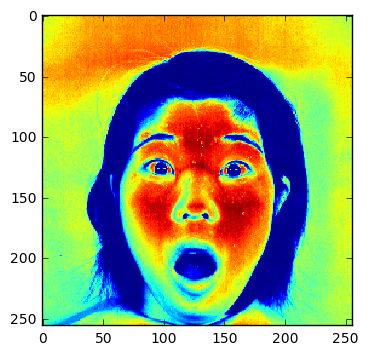

In [17]:
plt.imshow(mat)

In [18]:
fftw.idct(mat)

In [19]:
# la suite n'est plus correcte depuis cvxopt.fftw 
# au lieu de scipy.fftpack

In [20]:
x = transformed.flatten()
y = np.sort(x)

epsilon = 1e3

sig_coefs = np.sum(np.abs(y) > epsilon)

plt.title("Proportion of significant (>1e3) coefficients : {:.2f}%\n".format(
                                                    100*sig_coefs/y.shape[0]))
plt.plot(y);

NameError: name 'transformed' is not defined

La transformée permet de réduire fortement le nombre de coefficients à forte valeur absolue : $\theta = \Psi z$ est _sparse_.

On peut alors reconstruire le signal en inversant la transformée DCT :

In [21]:
rebuilt = scpfft.idct(transformed)

plt.imshow(rebuilt, cmap="gray");

NameError: name 'scpfft' is not defined

In [22]:
x = rebuilt.flatten()
y = np.sort(x)

epsilon = 1e3

sig_coefs = np.sum(np.abs(y) > epsilon)

plt.title("Proportion of significant (>1e3) coefficients : {:.2f}%\n".format(
                                                    100*sig_coefs/y.shape[0]))
plt.plot(y);

NameError: name 'rebuilt' is not defined

L'ensemble d'images de la classe $k$ est noté $\{x_{k,j} \:\: | \:\: j = 1 \dots J_k\}$, et l'on se propose de le résumer par $$\mathbf{y}_k = \bigg[x_{k,1}^T \dots x_{k,J_k}^T \bigg]^T$$ 
On note la représentation de cet ensemble dans la base DCT par :
$$\{X_{k,j} = \Psi x_{k,j}\}$$

Nous utilisons, sur cet ensemble transformé, la théorie du Distributed CS pour compresser l'information de chaque classe $k$ en :  
+ une composante commune, notée $\theta_k^c (= \Psi z_k^c)$
+ des innovations (pour chaque image), notées $\theta_{k,j}^i (= \Psi z_{k,j}^i) \quad j = 1 \dots J_k$

On note ces éléments sous la forme $\mathbf{W}_k = \bigg[ {\theta_k^c}^T {\theta_{k,1}^i}^T \dots {\theta_{k,J_k}^i}^T \bigg]^T$ (concaténation verticale des vecteurs).

En notant :
$$\widetilde{\Psi} = \begin{pmatrix}
    \Psi^T & \Psi^T & 0 & \dots & 0\\ 
    \Psi^T & 0 & \Psi^T & \ddots & \vdots\\ 
    \vdots & \vdots & \ddots & \ddots & 0\\ 
    \Psi^T & 0 & \dots & 0 & \Psi^T
\end{pmatrix}$$

Le modèle _**JSM**_ considéré correspond à $\mathbf{y}_k = \widetilde{\Psi}\mathbf{W}_k$.  
On cherche alors le vecteur $\mathbf{W}_k$ le plus _sparse_ possible, en essayant de résoudre le problème _Basis Pursuit_ :  

$$\arg \min ||\mathbf{W}_k||_1 \quad s.t. \:\; \mathbf{y}_k = \widetilde{\Psi}\mathbf{W}_k$$

Ou la relaxation sans contrainte :

$$\arg \min \Big\{ \tau ||\mathbf{W}_k||_1 \, + \, \frac{1}{2} ||\mathbf{y}_k - \widetilde{\Psi}\mathbf{W}_k ||_2^2 \Big\}$$

Cette forme relaxée est traitée dans [Gradient Projection for Sparse Reconstruction: Application to Compressed Sensing and Other Inverse Problems](http://nowak.ece.wisc.edu/GPSR.pdf). On cherche à implémenter l'algorithme dénommé **GPSR-Basic** dans l'article.

*ou pas* : [bitbucket.org/amitibo/pycompsense](https://bitbucket.org/amitibo/pycompsense/)

***

cf TP diagrammes de transition de phase

In [139]:
n = 64
N = n**2
J = 22

N*J

90112

(90112,)

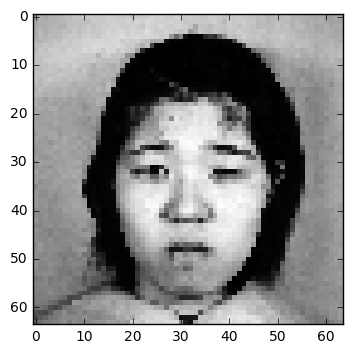

In [140]:
# define y_k

name = "KM"
data = []
j = 1

for fn in fnames:
    if fn[:2] == name:
        array = np.array(Image.open("jaffe/"+fn).resize((n,n)))
        data.append(array.flatten())
        if j==4:
            plt.imshow(array, cmap="gray")
        
        j+=1

y = np.hstack(data)

y.shape

In [141]:
y = y.astype(np.double)

In [43]:
y.dtype

dtype('float64')

In [44]:
cvxopt.matrix(y)

<2816x1 matrix, tc='d'>

In [142]:
identity = cvxopt.spmatrix(1.0, range(N), range(N))

In [143]:
left = cvxopt.sparse([identity for k in range(J)])

In [144]:
right = cvxopt.spdiag([identity for k in range(J)])

In [145]:
# on note A mais cela correspond au Psi_tilde
A = cvxopt.sparse([[left],[right]])

In [146]:
def cvx_mat(A, y):
    '''A, y: numpy array or cvx matrices
    return parameters c, G, h, A, b for CVXOPT solvers.lp method'''
    A = A
    y = cvxopt.matrix(y)
    m, N = A.size
    # matrix c, G, h, A, b
    c = cvxopt.matrix(np.ones(2*N))
    G = -cvxopt.spdiag([1]*2*N)
    h = cvxopt.matrix(np.zeros(2*N))
    A = cvxopt.sparse([[A],[-A]])
    b = y
    return c, G, h, A, b

In [147]:
c, G, h, A, b = cvx_mat(A,y)

In [46]:
print(c, '-'*10, '\n', G,'-'*10, '\n', h,'-'*10, '\n', A,'-'*10, '\n', b)

[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.

In [75]:
%%time

sol = cvxopt.solvers.lp(c, G, h, A, b)

     pcost       dcost       gap    pres   dres   k/t
 0:  1.2292e-11 -0.0000e+00  4e+06  2e+04  0e+00  1e+00
 1:  1.7484e+05  1.7485e+05  1e+06  5e+03  3e-16  1e+01
 2:  2.6594e+05  2.6595e+05  5e+05  2e+03  2e-16  5e+00
 3:  3.0891e+05  3.0892e+05  3e+05  1e+03  2e-16  3e+00
 4:  3.4636e+05  3.4636e+05  1e+05  6e+02  6e-16  2e+00
 5:  3.6745e+05  3.6745e+05  6e+04  3e+02  3e-16  9e-01
 6:  3.7855e+05  3.7855e+05  3e+04  1e+02  4e-16  4e-01
 7:  3.8427e+05  3.8427e+05  1e+04  5e+01  3e-16  2e-01
 8:  3.8717e+05  3.8717e+05  4e+03  2e+01  4e-16  7e-02
 9:  3.8829e+05  3.8829e+05  1e+03  5e+00  3e-16  2e-02
10:  3.8866e+05  3.8866e+05  2e+02  1e+00  3e-16  5e-03
11:  3.8875e+05  3.8875e+05  3e+01  1e-01  4e-16  7e-04
12:  3.8876e+05  3.8876e+05  5e+00  2e-02  4e-16  1e-04
13:  3.8876e+05  3.8876e+05  2e-01  9e-04  5e-16  4e-06
14:  3.8876e+05  3.8876e+05  2e-03  9e-06  3e-16  4e-08
15:  3.8876e+05  3.8876e+05  2e-05  9e-08  3e-16  4e-10
Optimal solution found.
CPU times: user 25min 42s,

In [76]:
sol

{'dual infeasibility': 3.3765864531785735e-16,
 'dual objective': 388764.4863184387,
 'dual slack': 2.0877567901993195e-12,
 'gap': 2.060255842150909e-05,
 'iterations': 15,
 'primal infeasibility': 9.492409341778147e-08,
 'primal objective': 388764.4863184358,
 'primal slack': 1.6814491545636252e-10,
 'relative gap': 5.299496005052643e-11,
 'residual as dual infeasibility certificate': None,
 'residual as primal infeasibility certificate': None,
 's': <47104x1 matrix, tc='d'>,
 'status': 'optimal',
 'x': <47104x1 matrix, tc='d'>,
 'y': <22528x1 matrix, tc='d'>,
 'z': <47104x1 matrix, tc='d'>}

In [126]:
theta = sol_glpk['x']

In [127]:
theta

<47104x1 matrix, tc='d'>

In [128]:
N*(J+1)*2

47104

In [129]:
theta = theta[:N*(J+1)] - theta[N*(J+1):]

In [130]:
theta_c = np.array(theta[:N])

In [131]:
sum(abs(theta_c))

array([ 59182.69921875])

In [132]:
sum(abs(theta_c) >= 30)

array([669])

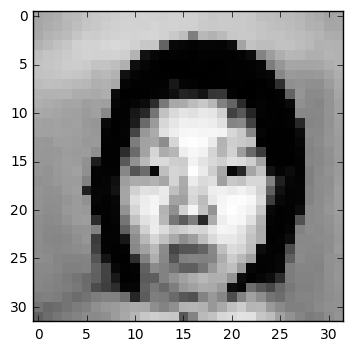

In [133]:
plt.imshow(theta_c.reshape((32,32)), cmap="gray")

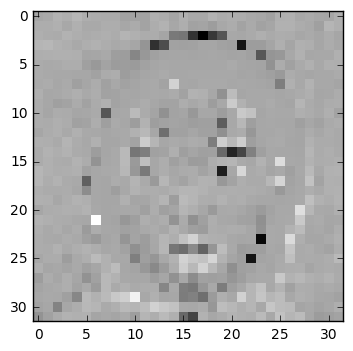

In [134]:
j = 4

theta_j = np.array(theta[N*j:N*(j+1)])
plt.imshow(theta_j.reshape((32,32)), cmap="gray")

In [135]:
sum(abs(theta_j))

array([ 10173.828125])

In [136]:
max(abs(theta_j))

array([ 171.18457031])

In [137]:
sum(abs(theta_j) >= 30)

array([72])

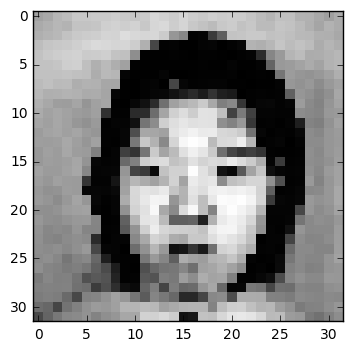

In [138]:
plt.imshow((theta_c + theta_j).reshape((32,32)), cmap="gray")

In [ ]:
%%time

sol_glpk = cvxopt.solvers.lp(c, G, h, A, b, solver="glpk")

In [125]:
sol_glpk

{'dual infeasibility': 0.0,
 'dual objective': 388764.486328125,
 'dual slack': -0.0,
 'gap': 0.0,
 'primal infeasibility': 0.0,
 'primal objective': 388764.486328125,
 'primal slack': 0.0,
 'relative gap': 0.0,
 'residual as dual infeasibility certificate': None,
 'residual as primal infeasibility certificate': None,
 's': <47104x1 matrix, tc='d'>,
 'status': 'optimal',
 'x': <47104x1 matrix, tc='d'>,
 'y': <22528x1 matrix, tc='d'>,
 'z': <47104x1 matrix, tc='d'>}

***
***
***

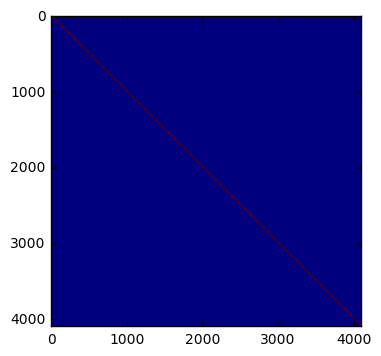

In [119]:
# on veut la matrice Psi
identity = np.eye(64**2)

plt.imshow(identity)

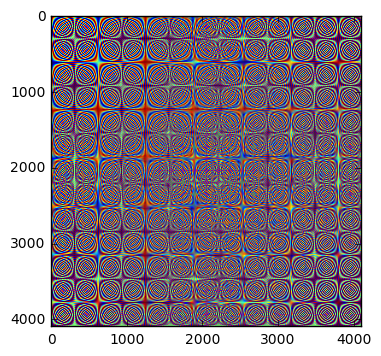

In [121]:
psi = scpfft.dct(identity)

plt.imshow(psi);

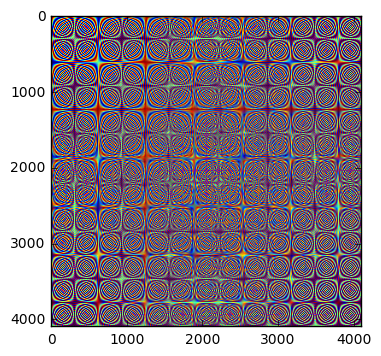

In [122]:
psi_t = scpfft.idct(identity)

plt.imshow(psi_t);

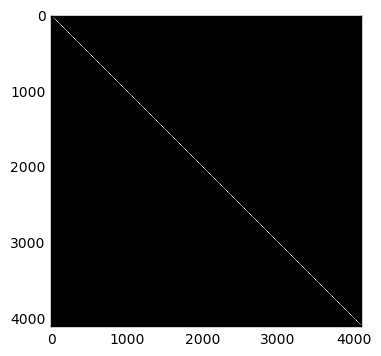

In [125]:
prod = psi_t.dot(psi)/8.192e3

plt.imshow(prod, cmap="gray");